In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import random as rnd
import torch
from torch import nn, optim, flatten, sigmoid
from torch.utils.data import TensorDataset, random_split, DataLoader

For GPU support:

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using " + device)
device = torch.device(device)

Using cuda



Define Neural Network Encoder/Decoder Structures:

In [4]:
class residualBlock(nn.Module):
    """ Residual Block, consisting of two channel and size invariant convolutions plus shortcut. """
    def __init__(self, channel_num, kernel_size, mode='encode'):
        super().__init__()

        padding = int((kernel_size-1)/2)
        if mode=='encode':
            conv1 = nn.Conv1d(channel_num, channel_num, kernel_size, padding=padding)
            conv2 = nn.Conv1d(channel_num, channel_num, kernel_size, padding=padding)
        elif mode=='decode':
            conv1 = nn.ConvTranspose1d(channel_num, channel_num, kernel_size, padding=padding)
            conv2 = nn.ConvTranspose1d(channel_num, channel_num, kernel_size, padding=padding)
        
        self.conv_block1 = nn.Sequential(conv1, nn.BatchNorm1d(channel_num), nn.ReLU()) 
        self.conv_block2 = nn.Sequential(conv2, nn.BatchNorm1d(channel_num), nn.ReLU()) 
        self.activation = nn.ReLU()

    def forward(self, x):
        residual = x
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x += residual
        out = self.activation(x)
        return out


class residualUnit(nn.Module):
    """ Residual Unit consisting of multiple residual Blocks. """
    def __init__(self, channel_in, channel_out, kernel_size, mode='encode'):
        super().__init__()

        # if necessary, perform dimension transformation to output channel
        if channel_in == channel_out:
            self.dimension_mismatch = False
        else:
            self.dimension_mismatch = True
            if mode=='encode':
                self.dim_transition = nn.Conv1d(channel_in, channel_out, kernel_size=1)
            elif mode=='decode':
                self.dim_transition = nn.ConvTranspose1d(channel_in, channel_out, kernel_size=1)

        self.res_blk1 = residualBlock(channel_out, kernel_size, mode)
        self.res_blk2 = residualBlock(channel_out, kernel_size, mode)

    def forward(self, x):
        x = self.dim_transition(x) if self.dimension_mismatch else x
        x = self.res_blk1(x)
        x = self.res_blk2(x)
        return(x)


class encoder(nn.Module):
    """ Encoder neural network consisting of 4 convolutional layers. """
    def __init__(self, latent_dim):
        super().__init__()
        self.activation = nn.ReLU()
        self.pool   = nn.MaxPool1d(3)
        self.conv1  = nn.Conv1d(1, 16, 7)
        self.conv2  = nn.Conv1d(16, 32, 6)
        self.conv3  = nn.Conv1d(32, 64, 6)
        self.conv4  = nn.Conv1d(64, 128, 5)
        self.dense1 = nn.Linear(1280, latent_dim)
        self.bn1 = nn.BatchNorm1d(16)
        self.bn2 = nn.BatchNorm1d(32)
        self.bn3 = nn.BatchNorm1d(64)
        self.bn4 = nn.BatchNorm1d(128)
        self.drop = nn.Dropout(0.3)
        
    def forward(self, input):
        out = self.pool(self.activation(self.conv1(input)))
        out = self.bn1(out)
        out = self.drop(out)
        out = self.pool(self.activation(self.conv2(out)))
        out = self.bn2(out)
        out = self.drop(out)
        out = self.pool(self.activation(self.conv3(out)))
        out = self.bn3(out)
        out = self.drop(out)
        out = self.pool(self.activation(self.conv4(out)))
        out = self.bn4(out)
        out = self.drop(out)
        out = flatten(out, 1)
        out = self.dense1(out)
        return out  


class residualEncoder(nn.Module):
    """ Encoder neural network consisting of 4 residual unis. """
    def __init__(self, latent_dim):
        super().__init__()
        self.pool   = nn.MaxPool1d(3)
        self.drop = nn.Dropout(0.3)
        self.resUnit1 = residualUnit(1, 16, kernel_size=3)
        self.resUnit2 = residualUnit(16, 32, kernel_size=3)
        self.resUnit3 = residualUnit(32, 64, kernel_size=3)
        self.resUnit4 = residualUnit(64, 128, kernel_size=3)
        self.dense    = nn.Linear(128*12, latent_dim)

    def forward(self, x):
        x = self.pool(self.resUnit1(x))       
        x = self.pool(self.resUnit2(x))
        x = self.pool(self.resUnit3(x))
        x = self.pool(self.resUnit4(x))
        x = flatten(x, 1)
        x = self.dense(x)
        return x  
    

class decoder(nn.Module):
    """ Decoder neural network consisting of 4 inverted convolutional layers. """
    def __init__(self, latent_dim):
        super().__init__()
        self.activation = nn.ReLU()
        self.dense1   = nn.Linear(latent_dim, 128*36)
        self.conv1T   = nn.ConvTranspose1d(128, 64, 7, stride=3)
        self.conv2T   = nn.ConvTranspose1d(64, 32, 6, stride=3)
        self.conv3T   = nn.ConvTranspose1d(32, 16, 6, stride=3)
        self.conv4T   = nn.ConvTranspose1d(16, 1, 5)
        self.bn1 = nn.BatchNorm1d(128)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(32)
        self.bn4 = nn.BatchNorm1d(16)
            
    def forward(self, input):
        out = self.activation(self.dense1(input))
        out = out.view(-1, 128, 36)
        out = self.bn1(out)
        out = self.activation(self.conv1T(out))
        out = self.bn2(out)
        out = self.activation(self.conv2T(out))
        out = self.bn3(out)
        out = self.activation(self.conv3T(out))
        out = self.bn4(out)
        out = sigmoid(self.conv4T(out))
        return out  


class autoencoder(nn.Module):
    """ Autoencoder for dimensionality reduction. """
    def __init__(self, latent_dim=32):
        super(autoencoder, self).__init__()
        self.encoder = encoder(latent_dim)
        self.decoder = decoder(latent_dim)
        
    def forward(self, input):
        encoded = self.encoder(input)
        decoded = self.decoder(encoded)
        return decoded

Data loading and preparation:

In [14]:
def loadDataSet(filename):
    with open(filename, 'rb') as f:
        dataSet = pickle.load(f)
    return np.asarray(dataSet)

def createDataset(X, device="cpu", batch_size=128, test_split=0.2):
    # split to test / train
    n_data = len(X)
    n_test = int(test_split*n_data)
    n_train = n_data - n_test

    X = torch.tensor(X, device=device)
    dataSet = TensorDataset(X.float())

    train_dataset, test_dataset = random_split(dataSet, [n_train, n_test])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

Setup Printing functions:

In [6]:
def printTrainingHistory(alpha, batch):
    file = "train_history_alpha_" + str(alpha) + "_batch_" + str(batch)
    if os.path.isfile(file):
        with open(file, 'rb') as f:
            hist = pickle.load(f)
    else: 
        print("No history!")
        return
    train_loss = [epoch[0] for epoch in hist]
    test_loss = [epoch[1] for epoch in hist]
    print("Training loss: {}, Test loss: {}".format(train_loss[-1], test_loss[-1]))
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.plot(train_loss, label='Train loss')
    ax.grid()
    ax.plot(test_loss, label='Test loss')
    ax.legend()
    plt.show()

def printSamplePredict(test_loader, AE, device, sample=1):
    n_subplots = 1
    plt.figure(figsize=(16,4))
    with torch.no_grad():
        jdx=0
        for batch in test_loader:
            jdx+=1
            batch_in = torch.reshape(batch[0].to(device), (batch[0].size()[0], 1, 1024))
            batch_enc = AE.encoder(batch_in)
            batch_out = AE(batch_in)
            if jdx==sample:
                for idx in range(n_subplots):
                    r = rnd.randint(0, len(batch))
                    plt.subplot(n_subplots,2,idx+1)
                    plt.plot(np.squeeze(batch_in[r].cpu().detach().numpy()), label='Original')
                    plt.plot(np.squeeze(batch_out[r].cpu().detach().numpy()), '--', label='Reconstructed')
                    plt.legend()
                    plt.subplot(n_subplots,2,idx+2)
                    plt.plot(np.squeeze(batch_enc[r].cpu().detach().numpy()))
                break
    plt.show()


Train the Autoencoder:



In [15]:
# load data
print("----------- Loading data -----------")
X = loadDataSet('DataFilteredNormalizedAugmented')
print("Done")

----------- Loading data -----------


100%|██████████| 24251/24251 [00:00<00:00, 2277412.32it/s]

Done


---------- Creating model ----------
---------- Start training ----------
epoch : 1/130, loss = 271.52, test loss = 52.88
epoch : 2/130, loss = 33.10, test loss = 28.08
epoch : 3/130, loss = 24.34, test loss = 23.76
epoch : 4/130, loss = 23.73, test loss = 23.63
epoch : 5/130, loss = 23.65, test loss = 23.57
epoch : 6/130, loss = 23.62, test loss = 23.56
epoch : 7/130, loss = 23.61, test loss = 23.55
epoch : 8/130, loss = 23.60, test loss = 23.55
epoch : 9/130, loss = 23.60, test loss = 23.55
epoch : 10/130, loss = 23.60, test loss = 23.54
epoch : 11/130, loss = 23.60, test loss = 23.55
epoch : 12/130, loss = 23.60, test loss = 23.54
epoch : 13/130, loss = 23.60, test loss = 23.54
epoch : 14/130, loss = 23.59, test loss = 23.54
epoch : 15/130, loss = 23.59, test loss = 23.54
epoch : 16/130, loss = 23.59, test loss = 23.54
epoch : 17/130, loss = 23.58, test loss = 23.54
epoch : 18/130, loss = 23.58, test loss = 23.53
epoch : 19/130, loss = 23.58, test loss = 23.53
epoch : 20/130, loss =

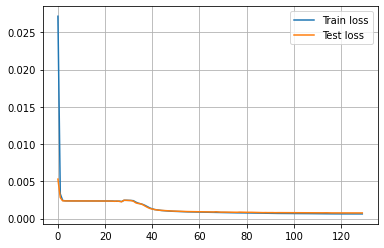

Training loss: 0.0006165488762474668, Test loss: 0.0007467416182503497


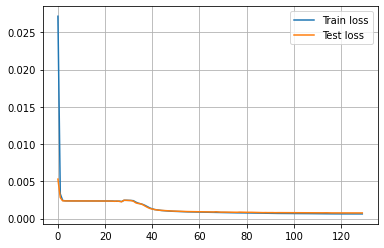

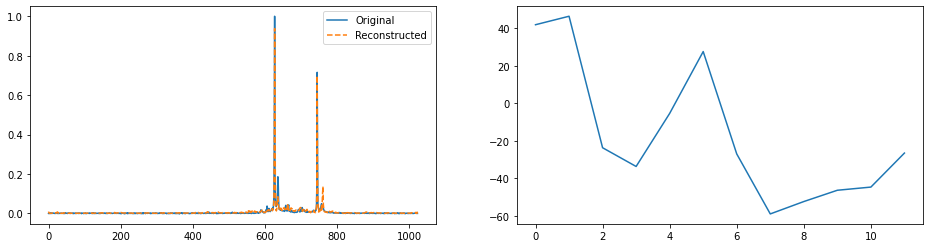

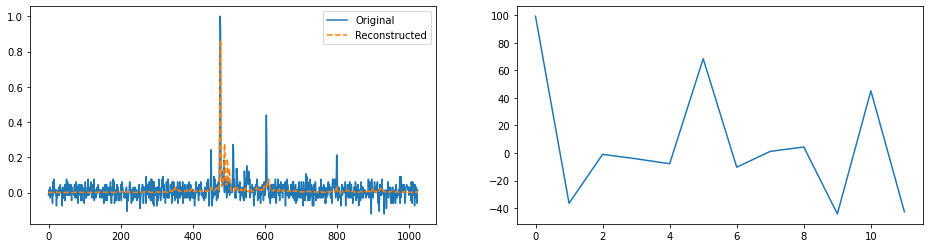

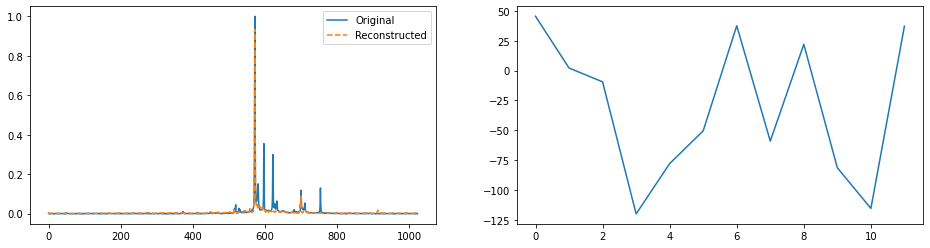

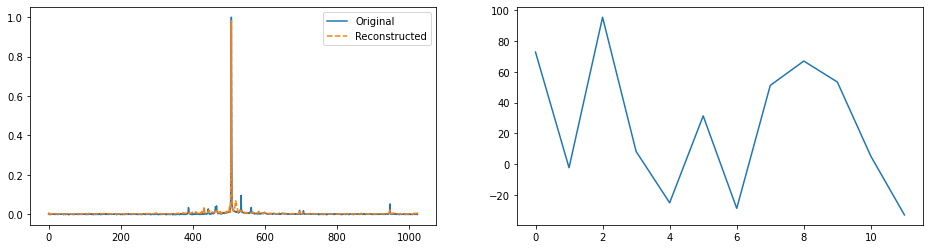

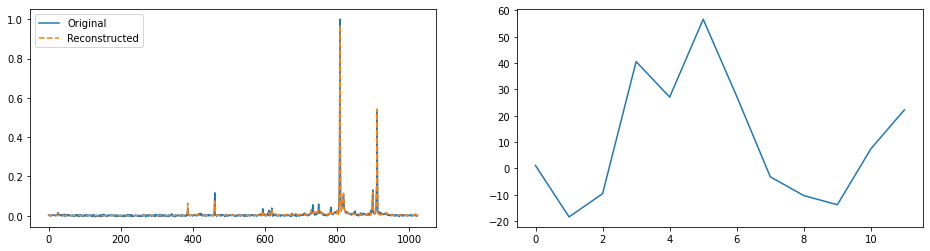

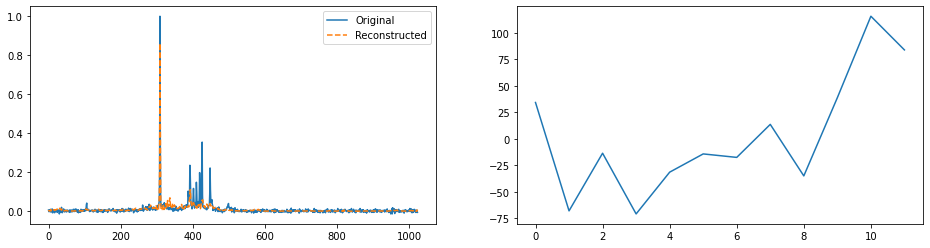

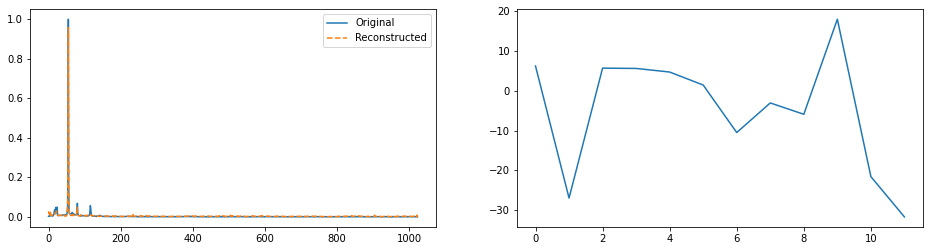

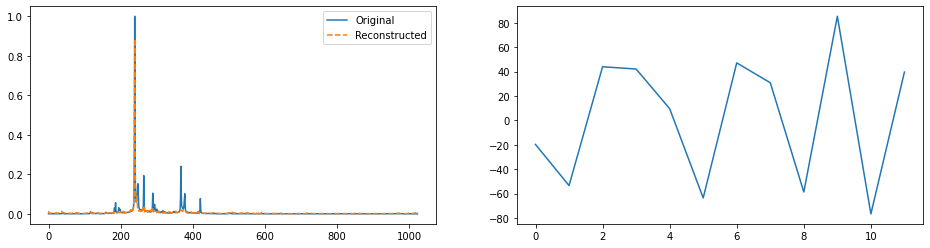

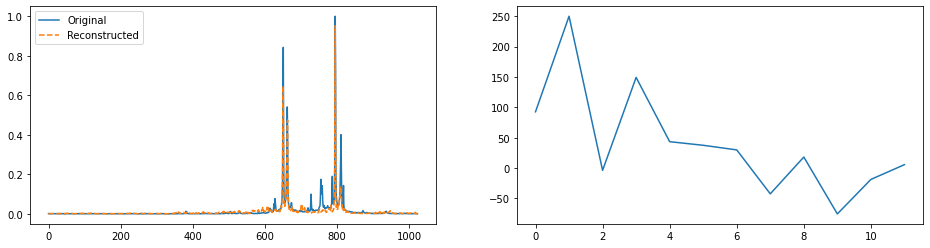

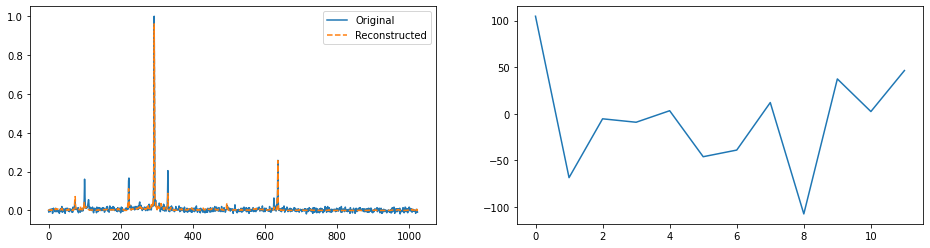

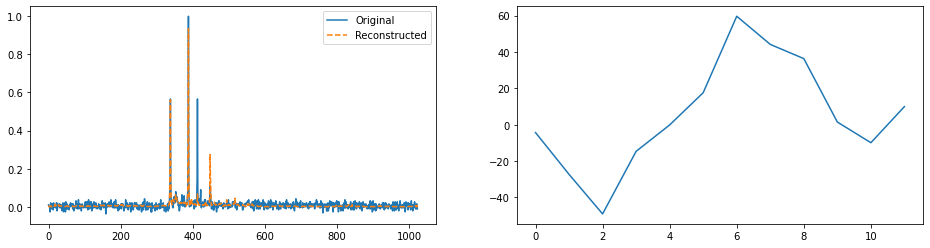

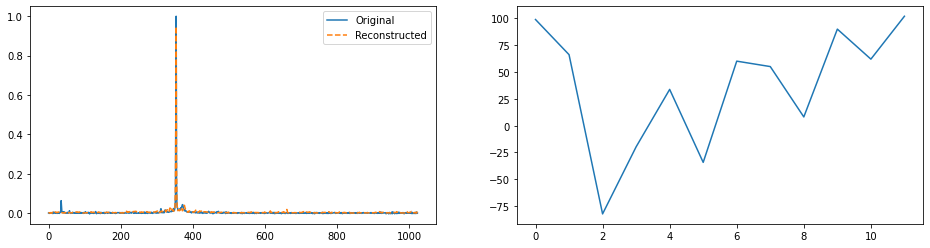

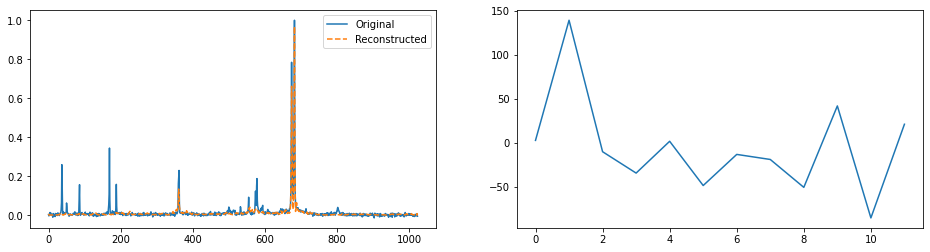

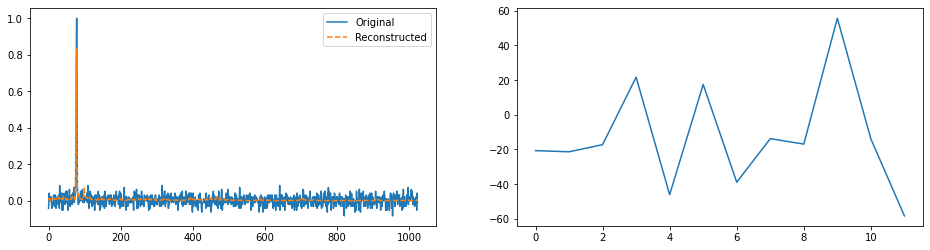

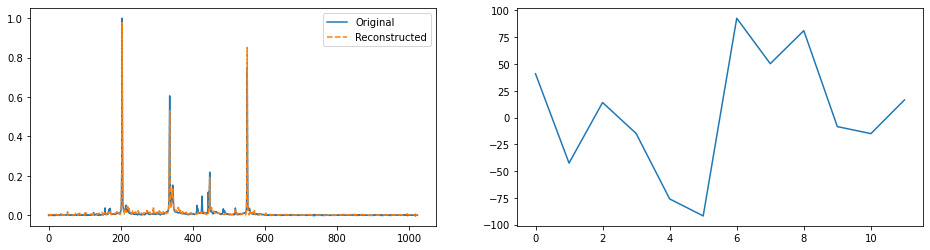

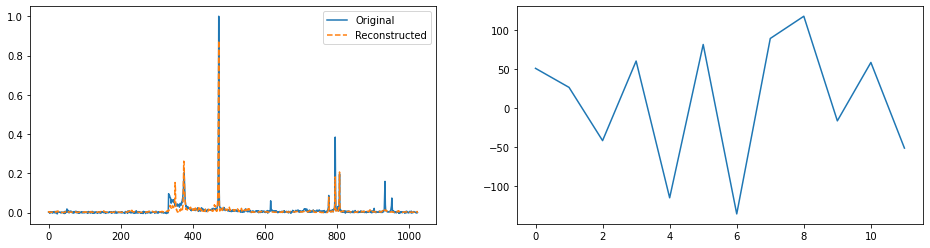

In [16]:
# hyperparameters
batch_size = 256
learning_rate = 0.01
latent_dim = 12

# dataset loader
train_loader, test_loader = createDataset(X, device, batch_size, test_split=0.2)

# instanciate model
print("---------- Creating model ----------")
autoencoder_model = autoencoder(latent_dim).to(device)
optimizer = optim.Adam(autoencoder_model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
#criterion = nn.L1Loss()

# train the model
epochs = 130
alpha_thresh = 1/10000 #0.2
track_count = 0
loss_storage = []
schedule_storage = []
print("---------- Start training ----------")
for epoch in range(epochs):

    # learning rate schedule:
    track_count += 1
    if track_count > 30:
        recent_loss = [epoch[0] for epoch in loss_storage[-30:]]
        change = np.std(recent_loss) #np.max(recent_loss) - np.min(recent_loss)
        if change < alpha_thresh:
            learning_rate = learning_rate / 2
            alpha_thresh = alpha_thresh / 2
            optimizer = optim.Adam(autoencoder_model.parameters(), lr=learning_rate)
            print("-------- Learning rate schedule performed from {0} to {1} ----------".format(2*learning_rate,learning_rate))
            schedule_storage.append(epoch)
            track_count = 0

    loss = 0
    for batch_original in train_loader:
        # preprocess batch as model input
        batch_original = torch.reshape(batch_original[0].to(device), (batch_original[0].size()[0], 1, 1024)).to(device)
        
        # reset gradient
        optimizer.zero_grad() 
        
        # compute loss
        batch_decoded = autoencoder_model(batch_original)
        train_loss = criterion(batch_decoded, batch_original)
        
        # compute gradient + perform gradient decent
        train_loss.backward()
        optimizer.step()
        
        loss += train_loss.item()
    
    # epoch training loss
    loss = loss / len(train_loader)
    
    # compute test loss
    with torch.no_grad():
        test_loss = 0
        for test_batch in test_loader:
            test_batch = torch.reshape(test_batch[0].to(device), (test_batch[0].size()[0], 1, 1024))

            test_batch_decoded = autoencoder_model(test_batch)
            test_loss += criterion(test_batch_decoded, test_batch).item()

        test_loss = test_loss / len(test_loader)
    
    loss_storage.append((loss, test_loss))
        
    print("epoch : {}/{}, loss = {:.2f}, test loss = {:.2f}".format(epoch + 1, epochs, loss*10000, test_loss*10000)) 


print("---------- Saving results ----------")
    
torch.save(autoencoder_model.encoder.state_dict(), "encoder8.pth")
torch.save(autoencoder_model.state_dict(), "autoencoder8.pth")

with open("train_history_alpha_" + str(learning_rate) + "_batch_" + str(batch_size), "wb") as fp:
    pickle.dump(loss_storage, fp)


print("--------- Printing results ----------")

printTrainingHistory(learning_rate, batch_size)

printTrainingHistory(learning_rate, batch_size)
for idx in range(12):
    printSamplePredict(test_loader, autoencoder_model, device, sample=idx+1)

Training loss: 0.0006165488762474668, Test loss: 0.0007467416182503497


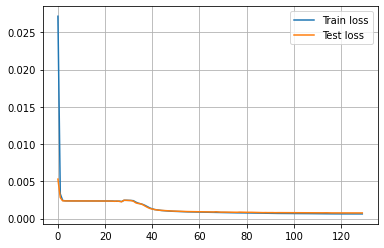

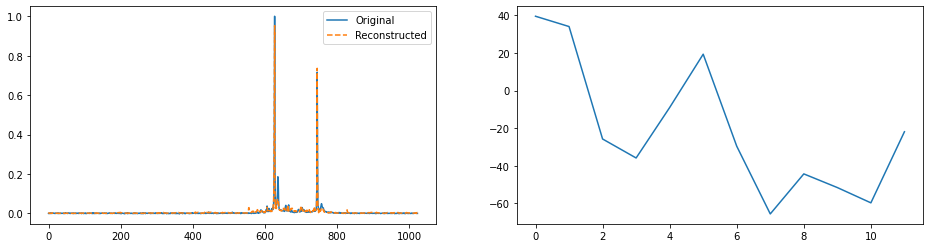

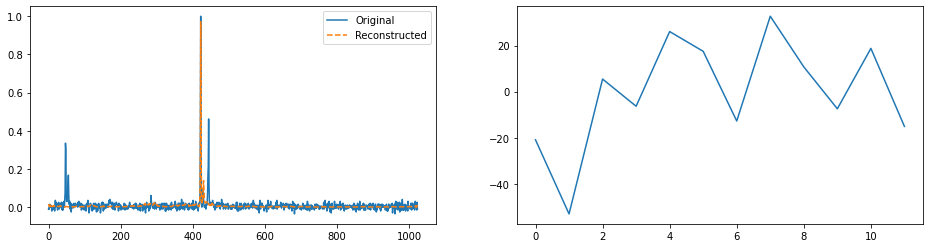

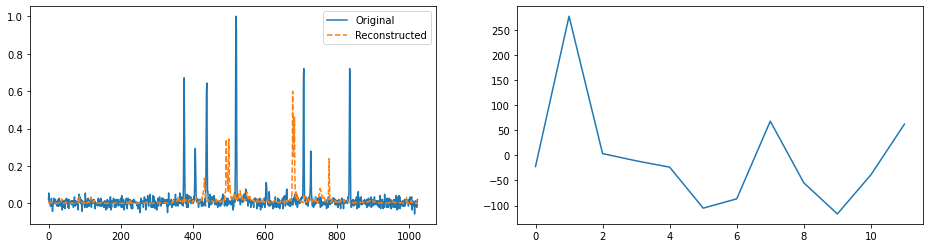

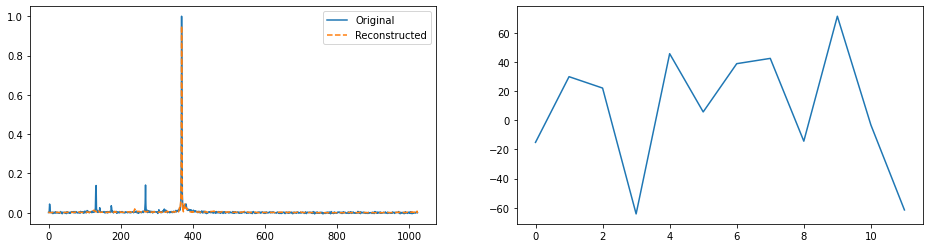

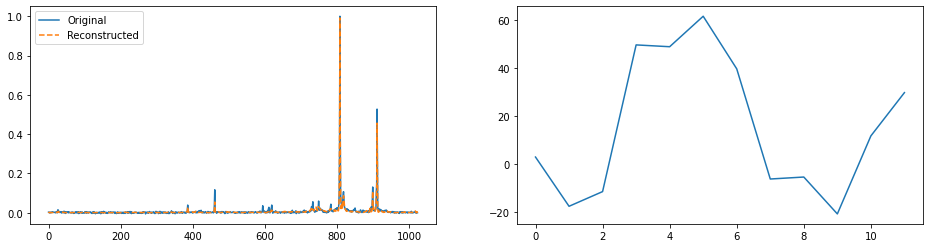

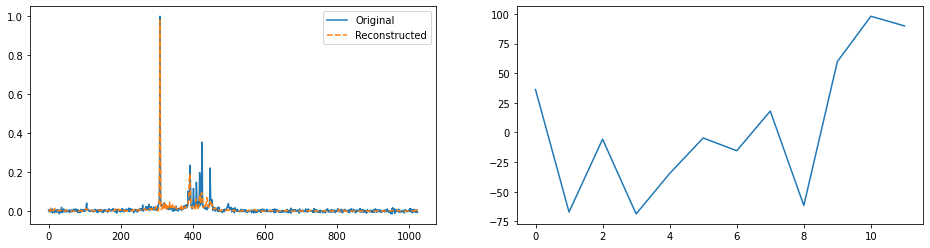

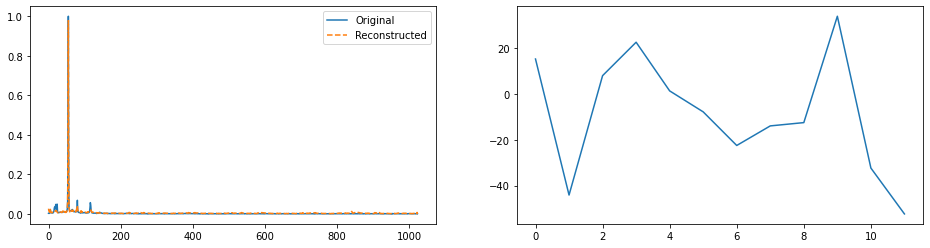

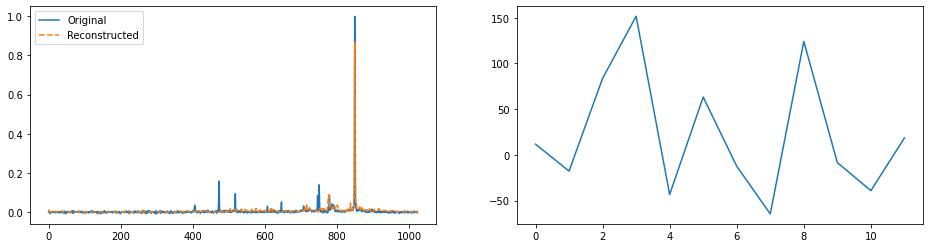

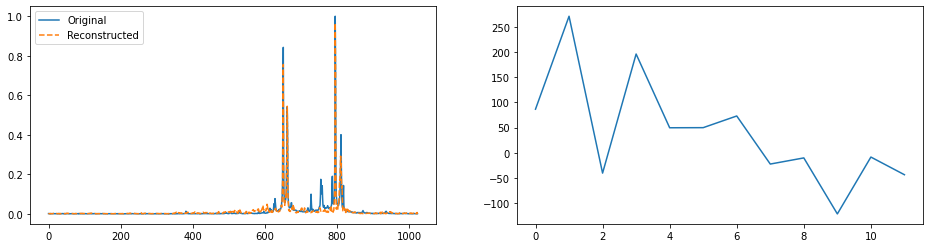

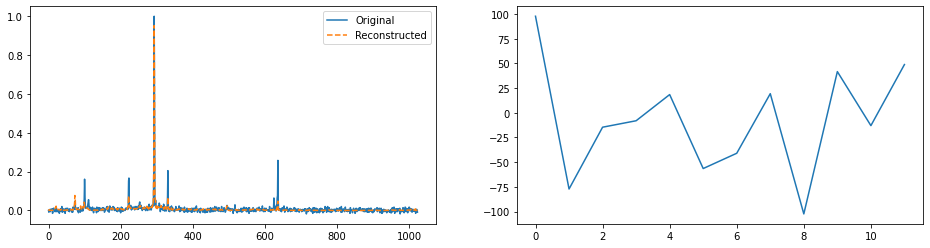

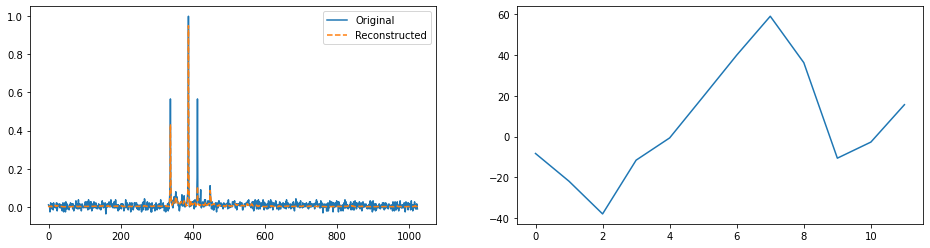

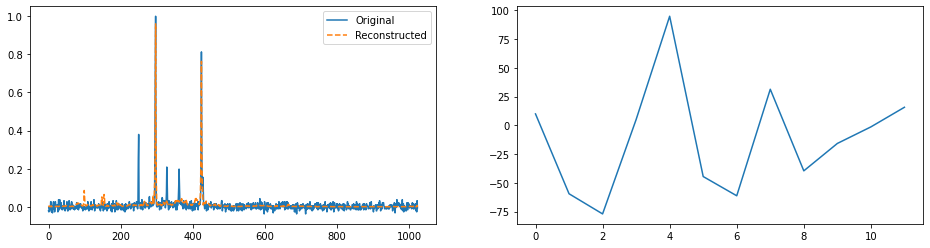

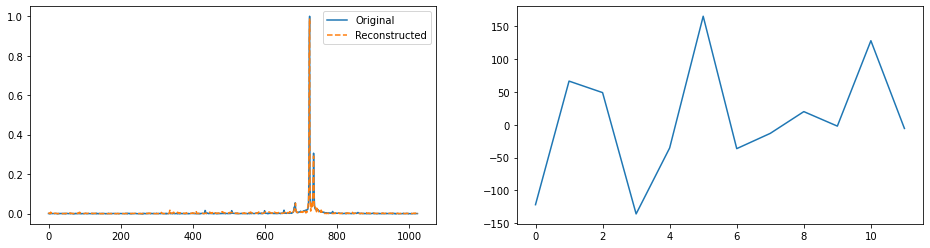

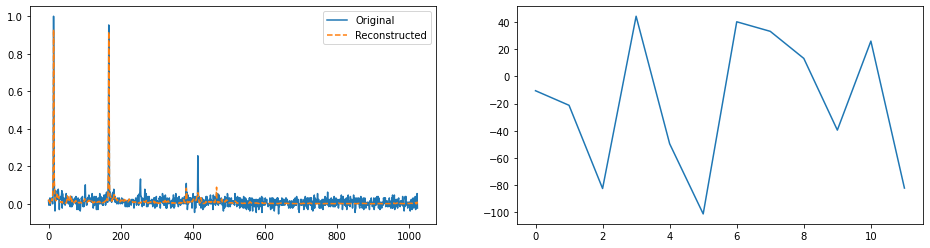

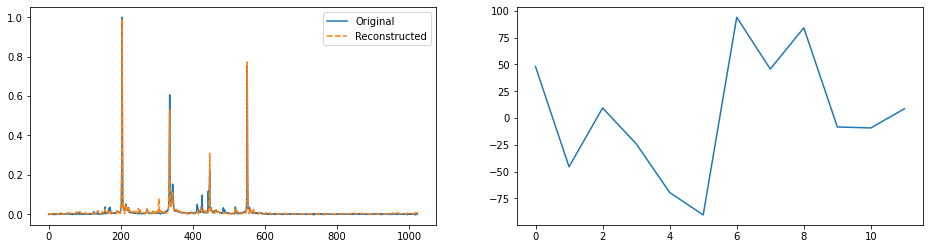

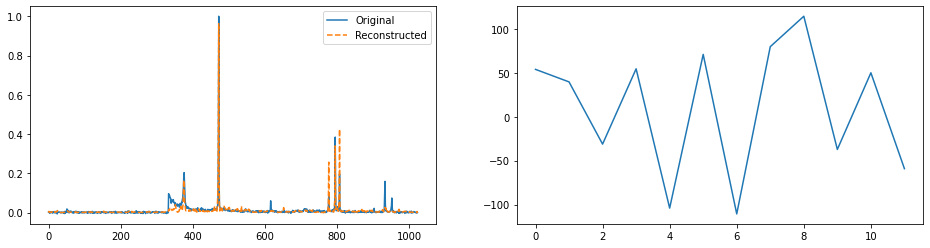

In [17]:
printTrainingHistory(learning_rate, batch_size)
for idx in range(16):
  printSamplePredict(test_loader, AE, device, sample=idx+1)
